# DSC 232 – Group Project  
**Dataset:** NYC For-Hire Vehicle (FHV) – Uber, Lyft, Juno, Via


# Milestone 2 – Exploratory Data Analysis (EDA)

The primary goal of this milestone is to perform exploratory data analysis on the NYC FHV dataset.

For full project details, see the [GitHub README](https://github.com/RezaMoghadam/Group-Project-Data-NYC-FHV/blob/main/README.md).


This project analyzes NYC For-Hire Vehicle (FHV) data, covering ride records from 2019 to 2022.  
It includes services like Juno, Uber, Lyft, and Via. The compressed dataset is approximately 19 GB in size.

Due to its scale, we use the San Diego Supercomputer Center (SDSC) to process the data using Apache Spark.


### Dataset Description

This analysis uses the **NYC High Volume For-Hire Vehicle (HVFHV)** trip data, which includes detailed records of rides dispatched by major services such as Uber, Lyft, Via, and Juno from 2019 onward.

Each row represents a single trip and includes fields such as:

- `pickup_datetime` / `dropoff_datetime`: Timestamps for the ride
- `trip_miles`: Distance of the trip in miles
- `trip_time`: Duration of the ride in seconds
- `base_passenger_fare`: Fare before additional fees or tips
- `driver_pay`: Net pay received by the driver
- `tips`, `tolls`, `sales_tax`, `airport_fee`, etc.: Breakdown of monetary components
- `PULocationID`, `DOLocationID`: Pickup and drop-off taxi zone identifiers
- Flags for shared rides, wheelchair accessibility, and MTA involvement

For full details, refer to the official [NYC TLC Data Dictionary (PDF)](sandbox:/mnt/data/data_dictionary_trip_records_hvfhs.pdf).


The main step is to start the Spark Session and configure the available resources.

In [3]:
import pyspark
print(pyspark.__version__)
from pyspark.sql import SparkSession

3.5.0


In [4]:
sc = SparkSession.builder \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "8g") \
    .config('spark.executor.instances', 5) \
    .config('spark.executor.cores', 2) \
    .getOrCreate()

Since the project files are in Parquet format, we use the appropriate app to read them. 

In [5]:
spark = SparkSession.builder \
    .appName("Read Parquet") \
    .getOrCreate()

We load all Parquet files into a PySpark DataFrame (`df`) and examine the schema and first 20 rows to understand the structure.

In [6]:
df = spark.read.parquet("Data/fhvhv_tripdata_*.parquet")


df.printSchema()
df.show(20)



root
 |-- hvfhs_license_num: string (nullable = true)
 |-- dispatching_base_num: string (nullable = true)
 |-- originating_base_num: string (nullable = true)
 |-- request_datetime: timestamp_ntz (nullable = true)
 |-- on_scene_datetime: timestamp_ntz (nullable = true)
 |-- pickup_datetime: timestamp_ntz (nullable = true)
 |-- dropoff_datetime: timestamp_ntz (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- trip_time: long (nullable = true)
 |-- base_passenger_fare: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- bcf: double (nullable = true)
 |-- sales_tax: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: integer (nullable = true)
 |-- tips: double (nullable = true)
 |-- driver_pay: double (nullable = true)
 |-- shared_request_flag: string (nullable = true)
 |-- shared_match_flag: string (nullable = true)
 |-- access_a_ride_

We check the total number of records in the dataset.

In [7]:
df.count()

745287023

We list all available columns in the DataFrame.

In [8]:
df.columns



['hvfhs_license_num',
 'dispatching_base_num',
 'originating_base_num',
 'request_datetime',
 'on_scene_datetime',
 'pickup_datetime',
 'dropoff_datetime',
 'PULocationID',
 'DOLocationID',
 'trip_miles',
 'trip_time',
 'base_passenger_fare',
 'tolls',
 'bcf',
 'sales_tax',
 'congestion_surcharge',
 'airport_fee',
 'tips',
 'driver_pay',
 'shared_request_flag',
 'shared_match_flag',
 'access_a_ride_flag',
 'wav_request_flag',
 'wav_match_flag']

# Data Cleaning

Some columns are not relevant to our analysis goals. We drop those unnecessary columns in the following step.

In [9]:
df = df.drop(*[col for col in df.columns if col.endswith("_flag")])


In [10]:
df.show()

+-----------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+----+---------+--------------------+-----------+----+----------+
|hvfhs_license_num|dispatching_base_num|originating_base_num|   request_datetime|  on_scene_datetime|    pickup_datetime|   dropoff_datetime|PULocationID|DOLocationID|trip_miles|trip_time|base_passenger_fare|tolls| bcf|sales_tax|congestion_surcharge|airport_fee|tips|driver_pay|
+-----------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+------------+------------+----------+---------+-------------------+-----+----+---------+--------------------+-----------+----+----------+
|           HV0003|              B02867|              B02867|2019-02-01 00:01:26|2019-02-01 00:02:55|2019-02-01 00:05:18|2019-02-01 00:14:57|         245|         

We select the key features needed for analysis and drop rows containing null values.

In [11]:
important_cols = [
    "pickup_datetime", "dropoff_datetime", "trip_miles", "trip_time",
    "base_passenger_fare", "driver_pay", "PULocationID", "DOLocationID"
]

df = df.dropna(subset=important_cols)


We remove ride records with zero miles or zero fare, as they are likely invalid.

In [12]:
df = df.filter(
    "trip_miles > 0 AND trip_time > 0 AND base_passenger_fare >= 0 AND driver_pay >= 0"
)


We identify and remove outliers to ensure more reliable analysis.

In [13]:
df = df.filter("trip_miles < 100 AND trip_time < 7200 AND driver_pay < 500")


We count the remaining records to assess how many were removed.  
Approximately 2 million rows were dropped, which is relatively small compared to the total dataset size and should not affect overall model performance.

In [14]:
df.count()

743008421

The first plot shows the distribution of rides by hour of the day.

In [15]:
from pyspark.sql.functions import hour

df_by_hour = df.withColumn("hour", hour("pickup_datetime"))


In [16]:
hourly_counts = df_by_hour.groupBy("hour").count().orderBy("hour")


In [17]:
pdf = hourly_counts.toPandas()


Matplotlib created a temporary cache directory at /scratch/rmoghadam/job_39785815/matplotlib-3hd1t8xz because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


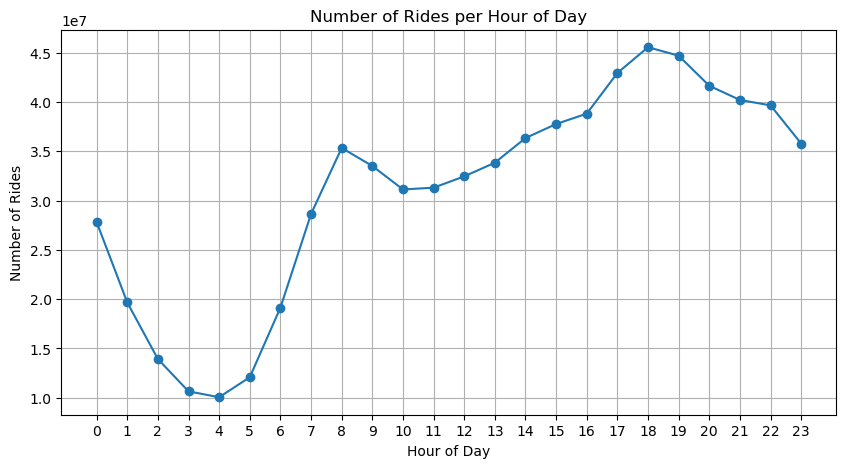

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(pdf["hour"], pdf["count"], marker='o')
plt.title("Number of Rides per Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Rides")
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()


As observed in the plot, 5–7 PM represents the peak demand period for for-hire vehicle rides.

The following plot examines ride volume by hour and day of the week.

In [19]:
from pyspark.sql.functions import date_format

df_hour_day = df.withColumn("hour", hour("pickup_datetime")) \
                .withColumn("weekday", date_format("pickup_datetime", "E"))  


# We can skip to Milestone 3 after running this cell

In [20]:
rides_by_hour_day = df_hour_day.groupBy("weekday", "hour").count()


In [21]:
pdf = rides_by_hour_day.toPandas()


from pandas.api.types import CategoricalDtype

weekday_order = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
pdf["weekday"] = pdf["weekday"].astype(CategoricalDtype(categories=weekday_order, ordered=True))
pdf = pdf.sort_values(["weekday", "hour"])


In [ ]:
import seaborn as sns
import pandas as pd

# Pivot table for heatmap
heatmap_data = pdf.pivot(index="weekday", columns="hour", values="count")

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="Blues", linewidths=0.5, annot=False)
plt.title("Ride Volume by Hour and Weekday")
plt.xlabel("Hour of Day")
plt.ylabel("Weekday")
plt.tight_layout()
plt.show()


The results indicate higher activity during weekend nights and Sunday mornings.  
Sunday evenings show a decline, likely as the city winds down before the start of the workweek.

The next plot compares average trip distance and fare across different hours of the day.

In [ ]:
df_with_hour = df.withColumn("hour", hour("pickup_datetime"))


In [ ]:
avg_miles = df_with_hour.groupBy("hour").avg("trip_miles").orderBy("hour")


In [ ]:
avg_fare = df_with_hour.groupBy("hour").avg("base_passenger_fare").orderBy("hour")


In [ ]:
avg_metrics = df_with_hour.groupBy("hour").agg(
    {"trip_miles": "avg", "base_passenger_fare": "avg"}
).orderBy("hour")


In [ ]:
pdf = avg_metrics.toPandas()
pdf.columns = ["hour", "avg_trip_miles", "avg_base_fare"]


In [ ]:

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel("Hour of Day")
ax1.set_ylabel("Avg Trip Miles", color="tab:blue")
ax1.plot(pdf["hour"], pdf["avg_trip_miles"], color="tab:blue", marker="o", label="Avg Miles")
ax1.tick_params(axis='y', labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Avg Fare ($)", color="tab:red")
ax2.plot(pdf["hour"], pdf["avg_base_fare"], color="tab:red", marker="x", label="Avg Fare")
ax2.tick_params(axis='y', labelcolor="tab:red")

plt.title("Average Trip Distance and Fare by Hour")
fig.tight_layout()
plt.show()


Driving between 12 PM and 7 PM appears to yield lower fare-per-mile ratios, suggesting this may be a less profitable period for drivers.

This plot explores the relationship between trip distance and tip amount.

In [ ]:
sample_df = df.select("trip_miles", "tips").dropna().limit(10000000)
pdf = sample_df.toPandas()

plt.figure(figsize=(8, 6))
plt.scatter(pdf["trip_miles"], pdf["tips"], alpha=0.3, s=5)
plt.xlabel("Trip Miles")
plt.ylabel("Tips ($)")
plt.title("Trip Distance vs Tip")
plt.grid(True)
plt.show()


A positive correlation is observed, although tips do not increase proportionally with distance.

The next two plots is to view the relation between the Driver Pay and two main variables, Trip Duration and Trip Distance.

In [ ]:
sample_df = df.select("trip_time", "driver_pay") \
              .dropna() \
              .filter("trip_time > 0 AND driver_pay > 0") \
              .limit(10000000)

pdf = sample_df.toPandas()


In [ ]:
pdf["trip_time_minutes"] = pdf["trip_time"] / 60


In [ ]:


plt.figure(figsize=(10, 6))
plt.scatter(pdf["trip_time_minutes"], pdf["driver_pay"], alpha=0.3, s=5)
plt.xlabel("Trip Time (minutes)")
plt.ylabel("Driver Pay ($)")
plt.title("Trip Duration vs Driver Pay")
plt.grid(True)
plt.show()


### Trip Duration vs. Driver Pay

This plot illustrates the relationship between trip duration and driver pay.

As expected, longer trip durations generally correspond to higher driver earnings.  
However, the relationship may not be strictly linear due to factors such as traffic, minimum fare policies, and waiting time charges.


In [ ]:
sample_df = df.select("trip_miles", "driver_pay") \
              .dropna() \
              .filter("trip_miles > 0 AND driver_pay > 0") \
              .limit(10000000)

pdf = sample_df.toPandas()


In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(pdf["trip_miles"], pdf["driver_pay"], alpha=0.3, s=5)
plt.xlabel("Trip Miles")
plt.ylabel("Driver Pay ($)")
plt.title("Trip Distance vs Driver Pay")
plt.grid(True)
plt.show()


### Trip Distance vs. Driver Pay

This plot illustrates the relationship between trip distance (in miles) and driver pay.

Driver earnings increase with distance, reflecting the fare structure based on mileage.  
The spread of data points also indicates variability, suggesting other factors like time of day, traffic, and surge pricing may influence pay beyond just distance.



# Milestone 3
Selecting a Model to run for initial predictions

# Linear Regresson


Under this notebook, we perform preprocessing based on our initial run

First we select the important features for the model

In [22]:
feature_cols = [
    "trip_miles", "trip_time", "base_passenger_fare", "tips",
    "hour", "weekday","PULocationID", "DOLocationID"
]


In [23]:
from pyspark.sql.functions import dayofweek
df_hour_day = df_hour_day.withColumn("weekday", dayofweek("pickup_datetime").cast("int"))

In [24]:
from pyspark.sql import functions as F

Following our observations on previous notebook, Since data is skewed due to very high tips and long-distance fares, we remove the outliers using IQR.

We define the functions for IQR and Filter

In [27]:
def IQR_bounds(df, columns):
    quantiles = {
        col: df.approxQuantile(col, [0.25, 0.75], 0.01)
        for col in columns
    }
    bounds = {}
    for col, (q1, q3) in quantiles.items():
        iqr = q3 - q1
        bounds[col] = (q1 - 1.5 * iqr, q3 + 1.5 * iqr)
    return bounds

In [28]:
def filter_outliers(df, bounds):
    condition = None
    for col, (lower, upper) in bounds.items():
        col_condition = (F.col(col) >= lower) & (F.col(col) <= upper)
        condition = col_condition if condition is None else (condition & col_condition)
    return df.filter(condition)

In [ ]:
# df_sample = df_model.sample(fraction=0.01, seed=42)  # around 7 M rows

In [29]:
bounds = IQR_bounds(df_hour_day, feature_cols)
df_hour_day_filtered = filter_outliers(df_hour_day, bounds)

In [31]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_model = assembler.transform(df_hour_day_filtered).select("features", "driver_pay")


We use a sample of data to have the model train on 

In [32]:
df_sample = df_model.sample(fraction=0.01, seed=42)  # around 5.6 M rows
train, test = df_sample.randomSplit([0.8, 0.2], seed=42)


We import the model and define it

In [34]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol="features", labelCol="driver_pay")

We train the model

In [35]:
lr_model = lr.fit(train)

We evaluate the regression performance of the model by looking at RMSE, MAE, and R².

In [36]:
predictions_lr = lr_model.transform(test)

from pyspark.ml.evaluation import RegressionEvaluator

rmse_lr = RegressionEvaluator(labelCol="driver_pay", predictionCol="prediction", metricName="rmse").evaluate(predictions_lr)
r2_lr = RegressionEvaluator(labelCol="driver_pay", predictionCol="prediction", metricName="r2").evaluate(predictions_lr)
mae_lr = RegressionEvaluator(labelCol="driver_pay", predictionCol="prediction", metricName="mae").evaluate(predictions_lr)

print(f"Linear Regression:\n  RMSE: {rmse_lr:.2f} | MAE: {mae_lr:.2f} | R²: {r2_lr:.3f}")


Linear Regression:
  RMSE: 3.78 | MAE: 2.27 | R²: 0.753


RMSE and MAE show the deviation on model predictions from actual values. Since the RMSE is larger, the model is making large errors that model penalizes more.
R² shows that overall how well our model fits the data. 


We plot the predictions vs Actuals to analyze the predictions visually.

In [40]:
predictions_lr = lr_model.transform(test) # around 1.1 M

In [41]:
pdf_lr = predictions_lr.select("driver_pay", "prediction").sample(fraction=0.01, seed=42).toPandas() # around 11 K


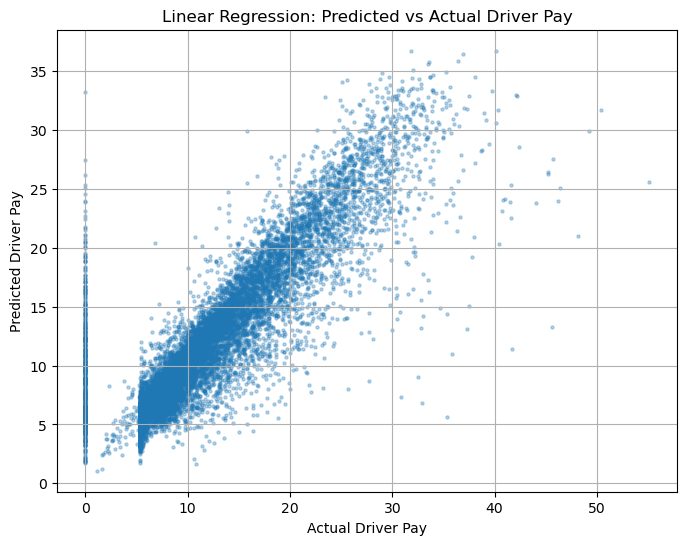

In [42]:
plt.figure(figsize=(8, 6))
plt.scatter(pdf_lr["driver_pay"], pdf_lr["prediction"], alpha=0.3, s=5)
plt.xlabel("Actual Driver Pay")
plt.ylabel("Predicted Driver Pay")
plt.title("Linear Regression: Predicted vs Actual Driver Pay")
plt.grid(True)
plt.show()

Still, the plot shows that we have a lot of predictions with values (non zero) that the driver pay is zero. This means that there are some data instances that have zero payments which is not correct. 

We remove the driver_pay row with zero pay

In [43]:
df_sample = df_sample.filter("driver_pay > 0") # around 5.37 M 

In [45]:
train, test = df_sample.randomSplit([0.8, 0.2], seed=42)

Repeat the training with optimized data

In [46]:
lr_model = lr.fit(train)

In [47]:
predictions_lr = lr_model.transform(test)

rmse_lr = RegressionEvaluator(labelCol="driver_pay", predictionCol="prediction", metricName="rmse").evaluate(predictions_lr)
r2_lr = RegressionEvaluator(labelCol="driver_pay", predictionCol="prediction", metricName="r2").evaluate(predictions_lr)
mae_lr = RegressionEvaluator(labelCol="driver_pay", predictionCol="prediction", metricName="mae").evaluate(predictions_lr)

print(f"Linear Regression:\n  RMSE: {rmse_lr:.2f} | MAE: {mae_lr:.2f} | R²: {r2_lr:.3f}")


Linear Regression:
  RMSE: 2.78 | MAE: 1.81 | R²: 0.852


The performance improved significantly specially on RMSE. Next we plot the predictions vs actuals again.

In [49]:
predictions_lr = lr_model.transform(test) # around 1.07 M


In [50]:
pdf_lr = predictions_lr.select("driver_pay", "prediction").sample(fraction=0.01, seed=42).toPandas() # around 10.7 K


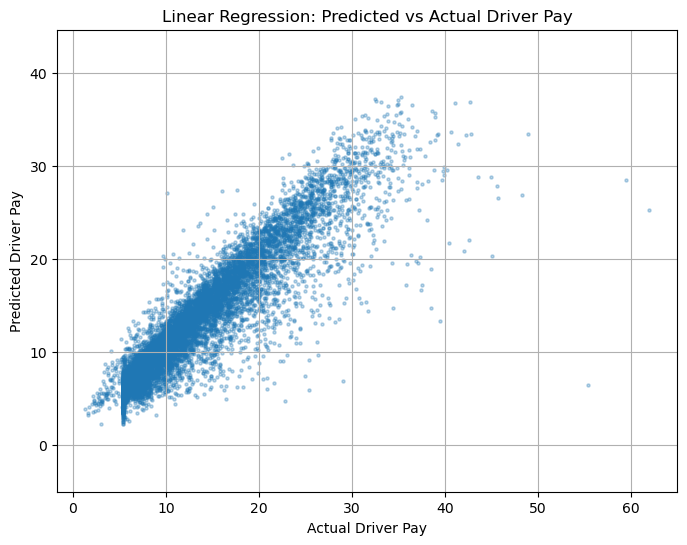

In [51]:
plt.figure(figsize=(8, 6))
plt.scatter(pdf_lr["driver_pay"], pdf_lr["prediction"], alpha=0.3, s=5)
plt.xlabel("Actual Driver Pay")
plt.ylabel("Predicted Driver Pay")
plt.title("Linear Regression: Predicted vs Actual Driver Pay")
plt.grid(True)
plt.axis("equal")
plt.show()

Under this plot format a line at 45 degree angle is a perfect model, our model is close to that line with some large errors that the high RMSE has pointed out previously.

# Conclusion of Milestone 3

Although the performance of the Linear Regression is in acceptable range, the model require better performance to be considered for prodution. Next step is to train other models with the main goal of fitting the non linearities due to high tips and long rides. Other models like Ridge regression with Polynomial features and GBT regressor.    